### GCN
Dataset is Zachary's Karate Club - 34 nodes (people), edges represents social interaction outside the context of karate club. Community labels we will try to predict.
<br> <br>
Message passing algorithm:
$$
 A \cdot F
$$
That's simple matrix multiplication. $A$ is denoted as adjacency matrix and $F$ as a feature vector of given nodes. Let's call result of this multiplication a neighborhood aggregation of messages.<br> <br>
We can also use different method. Not summing each feature but taking an average for a particular node. Degree matrix - denoted as $D$ would be helpful in this case, in which diagonal elements represents a degree of each node.

$$
    D^{-1}A=A_{avg}
$$

Self connection is required to include node's own value while aggregating messages.

$$
    \tilde{A} = A + I 
$$
$$
    \hat{A} = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}
$$
$$
    \hat{A}_{i,j} = \frac{1}{\sqrt{\tilde{d_i}\tilde{d_j}}}\tilde{A}_{i,j}
$$

It is used to normalize connections in the adjacency matrix by using neighborhood sizes on both source and destination nodes. This is essentialy convolution operation on graphs. <br> <br>

By repeatedly applying this normalization to the adjacency matrix the signal can travel to more distant neighborhoods in graph and eventually will reach the steady state (water drop experiment). <br> <br>

Passing a graph conv layer:
$$ H^{l+1} = \sigma(W\hat{A}H^l) $$ 
where $ A H^l $ is a message passing step.

In a nutshell each value of node in GCN layer:
- aggregate data from its neighbours,
- pass through fully connected net to obtain node embedding <br>



If long range connections are important to a problem there is a need for more GCN layers.

Based on: <a href="https://www.youtube.com/watch?v=ijmxpItkRjc">video 1</a>, <a href="https://www.youtube.com/watch?v=2KRAOZIULzw">video 2</a>.

In [1]:
import numpy as np
from scipy.linalg import sqrtm 
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm

In [2]:
A = np.array(
    [[0, 1, 0, 0, 0], 
     [1, 0, 1, 0, 0], 
     [0, 1, 0, 1, 1], 
     [0, 0, 1, 0, 0], 
     [0, 0, 1, 0, 0]]
)

In [3]:
feats = np.arange(1, A.shape[0] + 1).reshape(-1,1) # column vector

In [4]:
H = A @ feats # column vector

In [5]:
D = np.zeros(A.shape)
np.fill_diagonal(D, A.sum(axis=0)) # degree matrix - degrees on diagonal

In [6]:
D_inv = np.linalg.inv(D)
H_avg = D_inv @ A @ feats  # column vec

In [7]:
g = nx.from_numpy_array(A)
A_mod = A + np.eye(g.number_of_nodes())
D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, A_mod.sum(axis=0).flatten())
D_mod_invroot = np.linalg.inv(sqrtm(D_mod))

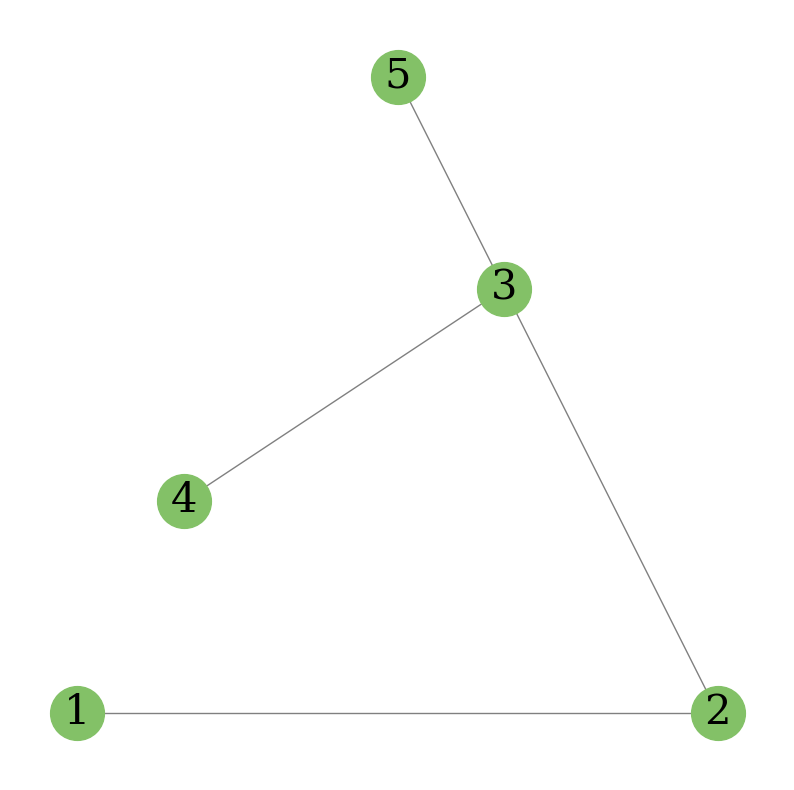

In [8]:
node_labels = {i: i+1 for i in range(g.number_of_nodes())}
pos = nx.planar_layout(g)

fig, ax = plt.subplots(figsize=(10,10))
nx.draw(
    g, pos, with_labels=True, 
    labels=node_labels, 
    node_color='#83C167', 
    ax=ax, edge_color='gray', node_size=1500, font_size=30, font_family='serif'
)
plt.savefig('simple_graph.png', bbox_inches='tight', transparent=True)

### Karate Club Visualisation

In [9]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)

In [10]:
g = nx.karate_club_graph()
g.number_of_nodes(), g.number_of_edges()

(34, 78)

In [11]:
communities = greedy_modularity_communities(g)

In [12]:
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i

n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]

In [13]:
communities[-1]

frozenset({0, 4, 5, 6, 10, 11, 16, 19})

In [14]:
club_labels = nx.get_node_attributes(g,'club')

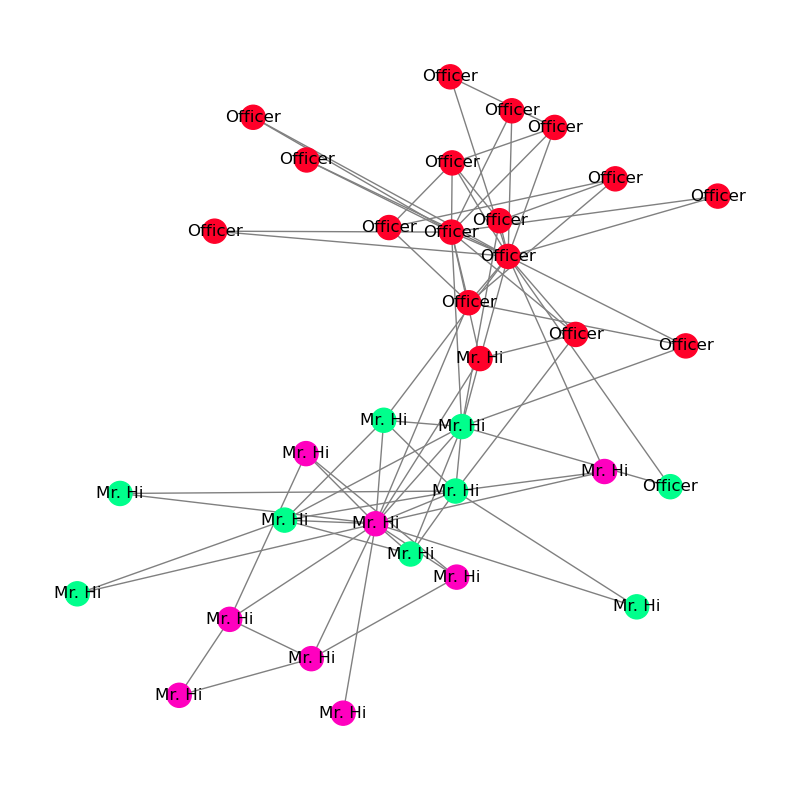

In [15]:
_ = draw_kkl(g, club_labels, colors, cmap='gist_rainbow', edge_color='gray')

In [16]:
A = nx.to_numpy_matrix(g)
A

matrix([[0., 4., 5., ..., 2., 0., 0.],
        [4., 0., 6., ..., 0., 0., 0.],
        [5., 6., 0., ..., 0., 2., 0.],
        ...,
        [2., 0., 0., ..., 0., 4., 4.],
        [0., 0., 2., ..., 4., 0., 5.],
        [0., 0., 0., ..., 4., 5., 0.]])

### Planetoid classification

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv

In [18]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures()) # normalize the bag-of-words features
data = dataset[0]

print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print()
data = dataset[0]  

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [19]:
print(data.x.shape) # nodes x features
# Features are bag-of-words vector in normalized form
data.x[0][:20]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111])

In [20]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [21]:
data.edge_index.t() # edge connections

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [22]:
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)

    # x - node feature matrix
    # edge_index - edge index tensor representing connections
    def forward(self, x, edge_index):
        # 1st message passing layer
        x = self.gcn1(x, edge_index).relu()
        x = F.dropout(x, p=0.5)

        # 2nd message passing layer
        x = self.gcn2(x, edge_index).relu()
        x = F.dropout(x, p=0.4)

        x = F.log_softmax(self.lin(x), dim=1)
        return x


In [23]:
in_channels = dataset.num_features
hidden_channels = 16
out_channels = dataset.num_classes

model = GNN(in_channels, hidden_channels, out_channels)
print(model)

GNN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=7, bias=True)
)


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

In [25]:
lr = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
# weight decay is regularization technique, L2 error usually
criterion = torch.nn.NLLLoss()

In [26]:
def train(model):
    model.train()
    optimizer.zero_grad()
    y_hat = model(data.x, data.edge_index)
    loss = criterion(y_hat[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model):
    model.eval()
    y_hat = model(data.x, data.edge_index)
    pred = y_hat.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

In [27]:
losses = []
for epoch in tqdm(range(2000)):
    loss = train(model)
    losses.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

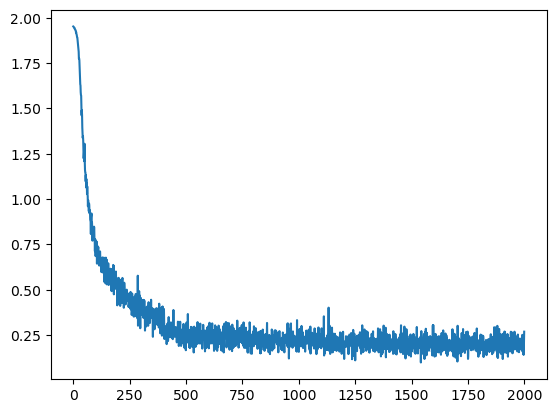

In [28]:
plt.plot(losses)

In [29]:
test_acc = test(model)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6680


### Planetoid using Lightning

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from torchsummary import summary

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ProgressBar

In [65]:
class LitGNN(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(LitGNN, self).__init__()
        self.task = task
        
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        
        for _ in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim)
        )
        
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

        self.dataset = Planetoid(root='/tmp/cora', name='cora')

        self.test_correct = 0
        self.test_total = 0
    
    def build_conv_model(self, input_dim, hidden_dim):
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        emb, y_hat = self(batch)
        y = batch.y
        if self.task == 'node':
            y_hat = y_hat[batch.train_mask]
            y = y[batch.train_mask]
        loss = F.nll_loss(y_hat, y)

        pred_label = y_hat.argmax(dim=1)
        correct = (pred_label == y).sum().item()
        acc = correct / len(y)
        self.log("train loss", loss, prog_bar=True, on_step=True)
        self.log("train acc", acc, prog_bar=True, on_step=True)
        return loss
        
    # def validation_step(self, batch, batch_idx):
    #     pass
    
    def test_step(self, batch, batch_idx):
        emb, y_hat = self(batch)
        y = batch.y
        if self.task == 'node':
            y_hat = y_hat[batch.test_mask]
            y = y[batch.test_mask]

        pred_label = y_hat.argmax(dim=1)
        correct = (pred_label == y).sum().item()
        self.test_correct += correct
        self.test_total += len(y)
        self.log("test acc", self.test_correct / self.test_total, prog_bar=True, on_step=True)
        return pred_label, y

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)
    
    def train_dataloader(self):
        if self.task == 'graph':
            data_size = len(self.dataset)
            train_loader = DataLoader(self.dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        else:
            train_loader = DataLoader(self.dataset, batch_size=64, shuffle=True)
        return train_loader

    # def val_dataloader(self):
    #     pass
    
    def test_dataloader(self):
        if self.task == 'graph':
            test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
        else:
            test_loader = DataLoader(self.dataset, batch_size=64, shuffle=True)
        return test_loader
        
    # def loss(self, pred, label):
    #     return F.nll_loss(pred, label)

In [66]:
dataset = Planetoid(root='/tmp/cora', name='cora')
input_dim, hidden_dim, output_dim = dataset.num_features, 32, dataset.num_classes
model = LitGNN(input_dim, hidden_dim, output_dim)

In [74]:
trainer = Trainer(max_epochs = 200)
torch.set_float32_matmul_precision('medium') # | 'high'
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | convs   | ModuleList | 48.0 K
1 | lns     | ModuleList | 128   
2 | post_mp | Sequential | 1.3 K 
---------------------------------------
49.4 K    Trainable params
0         Non-trainable params
49.4 K    Total params
0.198     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [75]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test acc_epoch         0.7576666474342346
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test acc_epoch': 0.7576666474342346}]

In [71]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [72]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 5428), started 0:59:19 ago. (Use '!kill 5428' to kill it.)